# 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import math
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import hdbscan
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Hyperparameters
BATCH_SIZE = 256
LR = 1e-3
EPOCHS_SIMCLR = 50     #Warmup
#Using rounded to balance between hard rounds and random rounds
TOTAL_TRIPLET_EPOCHS = 50
MARGIN = 1.0           #Distance between nodes needed to be clustered
RANDOM_EPOCHS_PER_CYCLE = 5
HARD_EPOCHS_PER_CYCLE = 1


Using device: cuda


# 2. Data Loading & Transformations (CIFAR-100)


In [2]:
#Define pre-processing transformations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor()
])

#Dataset
train_dataset_raw = datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)
test_dataset_raw = datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

100%|██████████| 169M/169M [00:03<00:00, 44.0MB/s]


# 3. Self-Supervised Warm-Up (SimCLR-like)


In [3]:
class SimCLRDataset(Dataset):
    #Takes the same image and mutates it in some way
    #While telling the network they're the same
    #Pulls out general features
    def __init__(self, base_dataset, transform=None, second_transform=None):
        super().__init__()
        self.base_dataset = base_dataset
        self.transform = transform
        self.second_transform = second_transform if second_transform else transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        raw_img = self.base_dataset.data[idx]
        pil_img = Image.fromarray(raw_img)
        img1 = self.transform(pil_img)
        img2 = self.second_transform(pil_img)
        return img1, img2


class SimpleConvBase(nn.Module):
    #Extremely basic CNN, probably need to make it more complex for better results
    def __init__(self, out_dim=128):
        super(SimpleConvBase, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  #16x16

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  #8x8

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(128, out_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class SimCLRModel(nn.Module):
    #Adds a projection head to the existing CNN to allow contrastive loss to function better
    def __init__(self, base_out_dim=128, projection_dim=64):
        super(SimCLRModel, self).__init__()
        self.encoder = SimpleConvBase(out_dim=base_out_dim)
        self.projection = nn.Sequential(
            nn.Linear(base_out_dim, base_out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(base_out_dim, projection_dim)
        )

    def forward(self, x):
        feat = self.encoder(x)
        proj = self.projection(feat)
        return feat, proj


def nt_xent_loss(z_i, z_j, temperature=0.5):
    #NT-Xent is a special loss function used to facilitate
    #Moving samples toward or away from one another
    batch_size = z_i.size(0)
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    logits = torch.matmul(z_i, z_j.t()) / temperature
    labels = torch.arange(batch_size).long().to(z_i.device)

    loss_i = F.cross_entropy(logits, labels)
    loss_j = F.cross_entropy(logits.t(), labels)
    return (loss_i + loss_j) / 2


# 4. SimCLR Training loop

In [ ]:
#SimCLR function
def train_simclr_epoch(model, loader, optimizer, epoch, temperature=0.5):
    model.train()
    total_loss = 0
    for img1, img2 in loader:
        img1 = img1.to(device)
        img2 = img2.to(device)

        optimizer.zero_grad()
        _, z1 = model(img1)
        _, z2 = model(img2)

        loss = nt_xent_loss(z1, z2, temperature=temperature)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"[SimCLR E{epoch}] Loss={avg_loss:.4f}")
    return avg_loss


simclr_dataset = SimCLRDataset(
    base_dataset=train_dataset_raw,
    transform=simclr_transform,
    second_transform=simclr_transform
)

simclr_loader = DataLoader(
    simclr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

simclr_model = SimCLRModel(base_out_dim=128, projection_dim=64).to(device)
optimizer_simclr = optim.Adam(simclr_model.parameters(), lr=LR)

print("SimCLR Warm-Up Training")
for e in range(1, EPOCHS_SIMCLR + 1):
    train_simclr_epoch(simclr_model, simclr_loader, optimizer_simclr, epoch=e, temperature=0.5)


# 5. Triplet Network & Datasets


In [ ]:
class TripletNet(nn.Module):
    #Augmenting the existing CNN to use the triplet system
    def __init__(self, encoder):
        super(TripletNet, self).__init__()
        self.encoder = encoder

    def forward(self, anchor, positive, negative):
        a = self.get_embedding(anchor)
        p = self.get_embedding(positive)
        n = self.get_embedding(negative)
        return a, p, n

    def get_embedding(self, x):
        #Get raw CNN output
        raw_emb = self.encoder(x)
        #Normalize to unit sphere
        emb = F.normalize(raw_emb, p=2, dim=1)
        return emb


def build_embedding_cache(model, dataset):
    #Store image embeddings rather than constantly recalculating
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    cache_list = []
    model.eval()
    with torch.no_grad():
        for (imgs, _) in loader:
            imgs = imgs.to(device)
            emb_batch = model.get_embedding(imgs).cpu().numpy()
            cache_list.append(emb_batch)
    return np.concatenate(cache_list, axis=0)


class TripletDataset(Dataset):
    #If hard_negative is set the system will select a negative which is located nearby
    #in order to challenge the network to find more underlying features
    def __init__(self, base_dataset, embedding_cache=None, hard_negative=False, K=20):
        super().__init__()
        self.base_dataset = base_dataset
        self.labels = np.array(base_dataset.targets)
        self.class_to_indices = {}
        for idx, lab in enumerate(self.labels):
            if lab not in self.class_to_indices:
                self.class_to_indices[lab] = []
            self.class_to_indices[lab].append(idx)

        self.embedding_cache = embedding_cache
        self.hard_negative = hard_negative
        self.K = K  # top-K nearest for negatives

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        anchor_img, anchor_label = self.base_dataset[index]

        #Positive
        pos_index = index
        while pos_index == index:
            pos_index = random.choice(self.class_to_indices[anchor_label])
        pos_img, _ = self.base_dataset[pos_index]

        #Negative
        if not self.hard_negative:
            #Random negative from another class
            neg_label = anchor_label
            while neg_label == anchor_label:
                neg_label = random.choice(list(self.class_to_indices.keys()))
            neg_index = random.choice(self.class_to_indices[neg_label])
        else:
            #Semi-hard negative from top-K nearest
            anchor_emb = self.embedding_cache[index]
            dists = np.sum((self.embedding_cache - anchor_emb)**2, axis=1)
            nearest_indices = np.argsort(dists)[1:self.K+1]
            candidate_neg = [i_n for i_n in nearest_indices if self.labels[i_n] != anchor_label]
            if len(candidate_neg) == 0:
                #If hard negative can't be found resort to random
                neg_label = anchor_label
                while neg_label == anchor_label:
                    neg_label = random.choice(list(self.class_to_indices.keys()))
                neg_index = random.choice(self.class_to_indices[neg_label])
            else:
                neg_index = random.choice(candidate_neg)

        neg_img, _ = self.base_dataset[neg_index]
        return anchor_img, pos_img, neg_img, anchor_label, anchor_label, self.labels[neg_index]


# 6. Triplet Training & Distance Checks

In [ ]:
#Triplet training function
def train_one_epoch_triplet(model, loader, optimizer, margin=MARGIN):
    model.train()
    total_loss = 0
    for (anchor_img, pos_img, neg_img, _, _, _) in loader:
        anchor_img = anchor_img.to(device)
        pos_img = pos_img.to(device)
        neg_img = neg_img.to(device)

        optimizer.zero_grad()
        a, p, n = model(anchor_img, pos_img, neg_img)

        dist_pos = F.pairwise_distance(a, p, p=2)
        dist_neg = F.pairwise_distance(a, n, p=2)
        loss = torch.clamp(dist_pos - dist_neg + margin, min=0).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

#Function to find embedding distances
def quick_distance_check(model, dataset, n_pairs=1000):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:2000]
    loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

    emb_list = []
    lbl_list = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            emb = model.get_embedding(imgs).cpu().numpy()
            emb_list.append(emb)
            lbl_list.append(labels.numpy())

    embeddings = np.concatenate(emb_list, axis=0)
    all_labels = np.concatenate(lbl_list, axis=0)
    n_data = embeddings.shape[0]

    same_dists = []
    diff_dists = []
    for _ in range(n_pairs):
        i1, i2 = np.random.randint(0, n_data, size=2)
        dist = np.linalg.norm(embeddings[i1] - embeddings[i2])
        if all_labels[i1] == all_labels[i2]:
            same_dists.append(dist)
        else:
            diff_dists.append(dist)

    if len(same_dists) > 0 and len(diff_dists) > 0:
        print(f"[DistCheck] same={np.mean(same_dists):.4f}, diff={np.mean(diff_dists):.4f}")
    else:
        print("Not enough pairs to measure.")


# 7. Spliced Triplet Training with Hard‐Neg Epochs

In [ ]:
triplet_model = TripletNet(simclr_model.encoder).to(device)
optimizer_triplet = optim.Adam(triplet_model.parameters(), lr=LR)

print("Spliced Triplet Training")
current_epoch = 1
epochs_left = TOTAL_TRIPLET_EPOCHS

while epochs_left > 0:
    #Random-negative epochs
    for i in range(min(epochs_left, RANDOM_EPOCHS_PER_CYCLE)):
        random_dataset = TripletDataset(
            base_dataset=train_dataset_raw,
            embedding_cache=None,
            hard_negative=False
        )
        random_loader = DataLoader(
            random_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            pin_memory=True
        )
        loss_r = train_one_epoch_triplet(triplet_model, random_loader, optimizer_triplet, margin=MARGIN)
        print(f"[Epoch {current_epoch}] RandomNeg Loss={loss_r:.4f}")
        quick_distance_check(triplet_model, train_dataset_raw)

        current_epoch += 1
        epochs_left -= 1
        if epochs_left <= 0:
            break

    if epochs_left <= 0:
        break

    #Hard-negative (semi-hard) epoch
    embed_cache = build_embedding_cache(triplet_model, train_dataset_raw)
    hard_dataset = TripletDataset(
        base_dataset=train_dataset_raw,
        embedding_cache=embed_cache,
        hard_negative=True,
        K=20  #pick from top-20 nearest
    )
    hard_loader = DataLoader(
        hard_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True
    )
    loss_h = train_one_epoch_triplet(triplet_model, hard_loader, optimizer_triplet, margin=MARGIN)
    print(f"[Epoch {current_epoch}] HardNeg Loss={loss_h:.4f}")
    quick_distance_check(triplet_model, train_dataset_raw)

    current_epoch += 1
    epochs_left -= 1

print("Finished Spliced Triplet Training")


=== Spliced Triplet Training ===
== Finished Spliced Triplet Training ==


# **Save & Load Code Block**


In [ ]:
def save_triplet_model(model, optimizer, epoch, filepath="triplet_model_checkpoint.pth"):
    """
    model: TripletNet instance
    optimizer: optimizer_triplet
    epoch: current epoch or training step
    filepath: where to save
    """
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }, filepath)
    print(f"Model saved to {filepath}")

def load_triplet_model(model, optimizer, filepath="triplet_model_checkpoint.pth"):
    """
    Load states into 'model' and 'optimizer'.
    """
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Model loaded from {filepath}, resume from epoch {start_epoch}")
    return start_epoch

In [ ]:
# === Save the model ===
save_triplet_model(triplet_model, optimizer_triplet, current_epoch, "triplet_model_checkpoint.pth")


Model saved to triplet_model_checkpoint.pth


In [ ]:
# === Load the model ===
resume_epoch = load_triplet_model(triplet_model, optimizer_triplet, "triplet_model_checkpoint.pth")


Model loaded from triplet_model_checkpoint.pth, resume from epoch 52


# 8. Data Visualization & Clustering

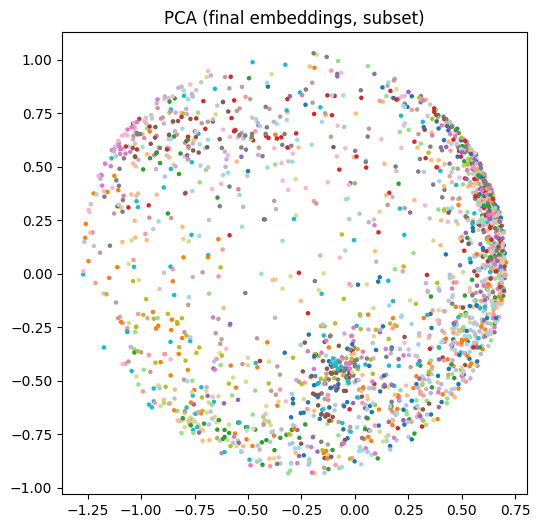

C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


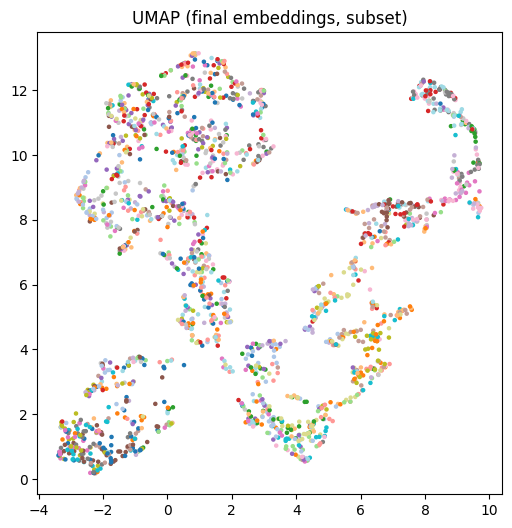

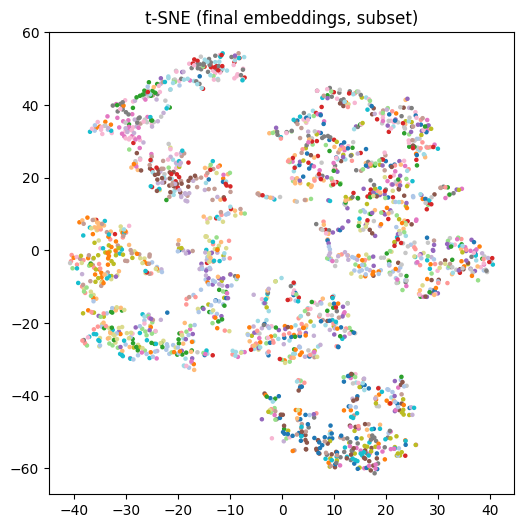

C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[HDBSCAN] Found 4 clusters (excluding noise label=-1).
 ARI=0.0151, NMI=0.2715


C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


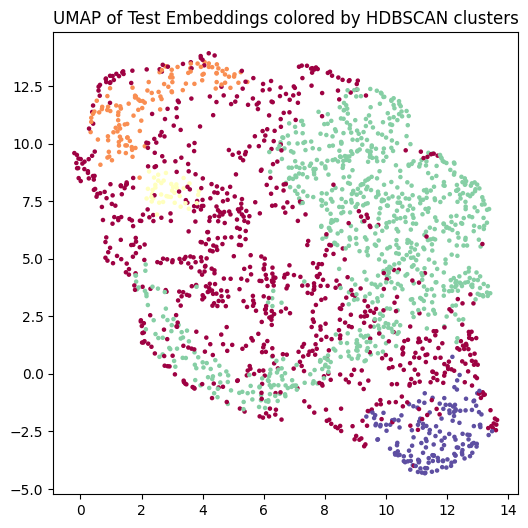

In [ ]:
def embedding_visuals(model, dataset, max_images=2000):
    """
    Generates PCA, UMAP, and t-SNE visualizations on a subset of 'dataset'.
    Colored according to ground-truth labels for reference.
    """

    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:max_images]

    sub_loader = DataLoader(
        Subset(dataset, indices),
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True
    )

    emb_list = []
    lbl_list = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in sub_loader:
            imgs = imgs.to(device)
            emb_batch = model.get_embedding(imgs).cpu().numpy()
            emb_list.append(emb_batch)
            lbl_list.append(labels.numpy())

    embeddings = np.concatenate(emb_list, axis=0)
    labels_np = np.concatenate(lbl_list, axis=0)

    #Principal Component Analysis
    #Finds directionality in data with the greatest variance
    #Simplified; it "kinda" maps features to a directional vector and each feature pushes
    #a data point in a direction
    pca = PCA(n_components=2, random_state=42)
    emb_pca = pca.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_pca[:,0], emb_pca[:,1], c=labels_np, cmap='tab20', s=5)
    plt.title("PCA (final embeddings, subset)")
    plt.show()

    #Uniform Manifold Approximation and Projection
    #Maps data based on how likely or unlikely each point is to be close to
    #each other then maps this fuzzy distance understanding to 2d space
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=42)
    emb_umap = reducer.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_umap[:,0], emb_umap[:,1], c=labels_np, cmap='tab20', s=5)
    plt.title("UMAP (final embeddings, subset)")
    plt.show()

    #t-Distributed Stochastic Neighbor Embeddings
    #Creates "neighborhoods" to find groups of data that would be close to one another
    #Then uses this fuzzy understanding to group data together
    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_tsne = tsne_model.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=labels_np, cmap='tab20', s=5)
    plt.title("t-SNE (final embeddings, subset)")
    plt.show()


def cluster_test_set_hdbscan(model, dataset, max_images=2000):
    #Clusters dataset with HBDSCAN
    #Prints ARI and NMI for debuging purposes

    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:max_images]

    loader = DataLoader(
        Subset(dataset, indices),
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True
    )

    emb_list = []
    lbl_list = []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            emb = model.get_embedding(imgs).cpu().numpy()
            emb_list.append(emb)
            lbl_list.append(lbls.numpy())

    embeddings = np.concatenate(emb_list, axis=0)
    labels_np = np.concatenate(lbl_list, axis=0)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
    preds = clusterer.fit_predict(embeddings)

    n_clusters = len(set(preds) - {-1})
    print(f"[HDBSCAN] Found {n_clusters} clusters (excluding noise label=-1).")

    valid_idx = preds != -1
    if np.sum(valid_idx) > 0:
        ari = adjusted_rand_score(labels_np[valid_idx], preds[valid_idx])
        nmi = normalized_mutual_info_score(labels_np[valid_idx], preds[valid_idx])
        print(f" ARI={ari:.4f}, NMI={nmi:.4f}")
    else:
        print(" No valid (non-noise) clusters for ARI/NMI.")

    #UMAP scatter for cluster visualization
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.5, random_state=42)
    emb_umap = reducer.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_umap[:,0], emb_umap[:,1], c=preds, cmap='Spectral', s=5)
    plt.title("UMAP of Test Embeddings colored by HDBSCAN clusters")
    plt.show()

embedding_visuals(triplet_model, test_dataset_raw, max_images=2000)
cluster_test_set_hdbscan(triplet_model, test_dataset_raw, max_images=2000)

# 9. Select & Cluster Initial Subset

In [ ]:
class UnlabeledSubset(Dataset):
    #Limits the amount of classes that can be used in the dataset
    def __init__(self, base_dataset, max_images=5000, max_classes=10):
        self.base_dataset = base_dataset
        labels_array = np.array(base_dataset.targets)
        unique_labels = np.unique(labels_array)
        random.shuffle(unique_labels)
        chosen_labels = unique_labels[:max_classes]

        indices = []
        for cl in chosen_labels:
            these_idx = np.where(labels_array == cl)[0]
            indices.extend(these_idx.tolist())
        random.shuffle(indices)
        indices = indices[:max_images]
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, lbl = self.base_dataset[real_idx]
        return img, lbl

print("Selecting subset images from limited classes")

#Replace 'train_dataset_raw' with base dataset
unlabeled_init_dataset = UnlabeledSubset(train_dataset_raw, max_images=5000, max_classes=10)
print(f"  => Subset size: {len(unlabeled_init_dataset)} images")

#Build embeddings for subset
loader_init = DataLoader(unlabeled_init_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
init_emb_list = []
init_labels_list = []
triplet_model.eval()
with torch.no_grad():
    for imgs, lbls in loader_init:
        imgs = imgs.to(device)
        emb_batch = triplet_model.get_embedding(imgs).cpu().numpy()
        init_emb_list.append(emb_batch)
        init_labels_list.extend(lbls.numpy())

init_embeddings = np.concatenate(init_emb_list, axis=0)
init_labels = np.array(init_labels_list)

clusterer_init = hdbscan.HDBSCAN(min_cluster_size=50)
init_preds = clusterer_init.fit_predict(init_embeddings)
unique_clusters_init = set(init_preds) - {-1}

cluster_buckets = {}
for cid in unique_clusters_init:
    cluster_buckets[cid] = []
cluster_buckets['noise'] = []

for i, c in enumerate(init_preds):
    if c == -1:
        cluster_buckets['noise'].append(i)
    else:
        cluster_buckets[c].append(i)

print("Initial Clusters")
for k in cluster_buckets:
    print(f"  Cluster {k}: size={len(cluster_buckets[k])}")



=== Selecting ~5000 images from up to 10 classes ===
  => Subset size: 5000 images


C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jason\anaconda3\envs\PyTorch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


=== Initial Clusters ===
  Cluster 0: size=420
  Cluster 1: size=185
  Cluster 2: size=1074
  Cluster 3: size=1250
  Cluster noise: size=2071


# 10. StreamingClusterManager + GravityTripletDataset


In [ ]:
#Class for triplet-trained dataset
class GravityTripletDataset(Dataset):
    def __init__(self, model, device, all_embeddings, base_dataset, triplets_info):
        self.model = model
        self.device = device
        self.all_embeddings = all_embeddings
        self.base_dataset = base_dataset
        self.triplets_info = triplets_info

    def __len__(self):
        return len(self.triplets_info)

    def __getitem__(self, idx):
        idx_img, pos_centroid, neg_centroid = self.triplets_info[idx]
        img, _ = self.base_dataset[idx_img]
        return (
            img,
            torch.tensor(pos_centroid, dtype=torch.float32),
            torch.tensor(neg_centroid, dtype=torch.float32),
        )

#Class for streaming images into existing clusters
class StreamingClusterManager:
    def __init__(
        self,
        model,
        device,
        init_embeddings,
        init_preds,
        init_labels,
        cluster_buckets,
        distance_threshold=1.5
    ):
        self.model = model
        self.device = device
        self.distance_threshold = distance_threshold
        self.all_embeddings = init_embeddings.copy()
        self.all_cluster_ids = init_preds.copy()
        self.all_labels = init_labels.copy()
        self.num_initial = self.all_embeddings.shape[0]

        self.cluster_buckets = {}
        for cid in cluster_buckets:
            self.cluster_buckets[cid] = []
        for cid in cluster_buckets:
            for idx_val in cluster_buckets[cid]:
                if idx_val < self.num_initial:
                    self.cluster_buckets[cid].append(idx_val)

        self.centroids = {}
        for cid in self.cluster_buckets:
            if len(self.cluster_buckets[cid]) > 0:
                emb_sub = self.all_embeddings[self.cluster_buckets[cid]]
                centroid = emb_sub.mean(axis=0)
                self.centroids[cid] = centroid

    #Assign image based on embedding distance
    def assign_new_image(self, img_tensor, true_label):
        if img_tensor.ndim == 3:
            img_tensor = img_tensor.unsqueeze(0)
        img_tensor = img_tensor.to(self.device)
        with torch.no_grad():
            emb = self.model.get_embedding(img_tensor).cpu().numpy()[0]

        if len(self.centroids) == 0:
            new_cid = 0
            self.cluster_buckets[new_cid] = [self.num_initial]
            self.all_cluster_ids = np.append(self.all_cluster_ids, new_cid)
            self.all_embeddings = np.vstack([self.all_embeddings, emb])
            self.all_labels = np.append(self.all_labels, true_label)
            self.centroids[new_cid] = emb
            self.num_initial += 1
            return (new_cid, 0.0)

        dists = {}
        for cid, cvec in self.centroids.items():
            dists[cid] = np.linalg.norm(emb - cvec)
        nearest_cid = min(dists, key=dists.get)
        nearest_dist = dists[nearest_cid]

        if nearest_dist > self.distance_threshold:
            new_cid = max([x for x in self.centroids.keys() if isinstance(x, int)], default=-1) + 1
            self.cluster_buckets[new_cid] = [self.num_initial]
            self.all_cluster_ids = np.append(self.all_cluster_ids, new_cid)
            self.all_embeddings = np.vstack([self.all_embeddings, emb])
            self.all_labels = np.append(self.all_labels, true_label)
            self.centroids[new_cid] = emb
            self.num_initial += 1
            return (new_cid, 0.0)
        else:
            idx_new = self.num_initial
            self.num_initial += 1
            self.all_cluster_ids = np.append(self.all_cluster_ids, nearest_cid)
            self.all_embeddings = np.vstack([self.all_embeddings, emb])
            self.all_labels = np.append(self.all_labels, true_label)
            self.cluster_buckets[nearest_cid].append(idx_new)

            old_count = len(self.cluster_buckets[nearest_cid]) - 1
            old_centroid = self.centroids[nearest_cid]
            new_count = old_count + 1
            new_centroid = (old_centroid * old_count + emb) / new_count
            self.centroids[nearest_cid] = new_centroid
            return (nearest_cid, nearest_dist)

    def periodic_recluster(self):
        if self.all_embeddings.shape[0] == 0:
            return
        clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
        new_preds = clusterer.fit_predict(self.all_embeddings)
        #Possibly reassign or merge clusters here if desired.

    #Gravity retraining; "pulls" data closer to its cluster center
    def gravity_retrain(
        self,
        optimizer,
        unlabeled_dataset,
        margin=1.0,
        epochs=3,
        outlier_cid="noise"
    ):
        all_triplets = []
        cluster_ids_list = sorted([c for c in self.cluster_buckets.keys() if isinstance(c, int)])
        if outlier_cid in self.cluster_buckets:
            cluster_ids_list.append(outlier_cid)

        for cid in cluster_ids_list:
            if cid not in self.cluster_buckets:
                continue
            indices_c = self.cluster_buckets[cid]
            if len(indices_c) < 10:
                continue
            random.shuffle(indices_c)
            sample_indices = indices_c[:50]
            other_cids = [x for x in cluster_ids_list if x != cid and x in self.cluster_buckets]
            if len(other_cids) == 0:
                continue
            neg_cid = random.choice(other_cids)
            if neg_cid not in self.centroids:
                continue
            if cid not in self.centroids:
                continue
            neg_centroid = self.centroids[neg_cid]
            pos_centroid = self.centroids[cid]
            for idx_img in sample_indices:
                all_triplets.append((idx_img, pos_centroid, neg_centroid))

        ds = GravityTripletDataset(
            self.model,
            self.device,
            self.all_embeddings,
            unlabeled_dataset,
            all_triplets
        )
        if len(ds) == 0:
            return
        loader = DataLoader(ds, batch_size=32, shuffle=True, pin_memory=True)
        for _ in range(epochs):
            self.model.train()
            for anchor_img, pos_vec, neg_vec in loader:
                anchor_img = anchor_img.to(self.device)
                optimizer.zero_grad()
                a_emb = self.model.get_embedding(anchor_img)
                pos_vec = pos_vec.to(self.device)
                neg_vec = neg_vec.to(self.device)
                dist_pos = F.pairwise_distance(a_emb, pos_vec, p=2)
                dist_neg = F.pairwise_distance(a_emb, neg_vec, p=2)
                loss = torch.clamp(dist_pos - dist_neg + margin, min=0).mean()
                loss.backward()
                optimizer.step()

    #Function for iteratively adding images to the clusters
    def iterative_streaming_cycle(
        self,
        new_dataset,
        optimizer,
        unlabeled_dataset,
        cycle_size=1000,
        total_images=5000,
        margin=1.0,
        retrain_epochs=3,
        outlier_cid="noise"
    ):
        images_streamed = 0
        while images_streamed < total_images:
            batch_end = min(images_streamed + cycle_size, total_images)
            for i in range(images_streamed, batch_end):
                if i >= len(new_dataset):
                    break
                img_tensor, lbl = new_dataset[i]
                self.assign_new_image(img_tensor, lbl)
            images_streamed = batch_end
            self.gravity_retrain(
                optimizer=optimizer,
                unlabeled_dataset=unlabeled_dataset,
                margin=margin,
                epochs=retrain_epochs,
                outlier_cid=outlier_cid
            )

    #Metrics for showing accuracy of clusters
    def compute_metrics(self):
        valid_mask = [i for i in range(len(self.all_cluster_ids)) if self.all_cluster_ids[i] != -1]
        assigned_clusters = self.all_cluster_ids[valid_mask]
        assigned_labels = self.all_labels[valid_mask]
        if len(set(assigned_clusters)) <= 1:
            return
        ari_val = adjusted_rand_score(assigned_labels, assigned_clusters)
        nmi_val = normalized_mutual_info_score(assigned_labels, assigned_clusters)
        print(f"ARI={ari_val:.4f}, NMI={nmi_val:.4f}")


# 11. Visualization, Loop & Summaries


In [ ]:
def plot_clusters(manager, max_points=2000):
    if manager.all_embeddings.shape[0] == 0:
        return
    if manager.all_embeddings.shape[0] > max_points:
        idx_subset = np.random.choice(manager.all_embeddings.shape[0], max_points, replace=False)
        emb_subset = manager.all_embeddings[idx_subset]
        clust_subset = manager.all_cluster_ids[idx_subset]
    else:
        emb_subset = manager.all_embeddings
        clust_subset = manager.all_cluster_ids

    #Convert outliers to -1 cluster to standardize to int
    clust_subset_str = clust_subset.astype(str)
    clust_subset_str[clust_subset_str == 'noise'] = '-1'
    clust_subset_str[clust_subset_str == '-1'] = '-1'
    clust_subset_int = clust_subset_str.astype(int)

    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_tsne = tsne_model.fit_transform(emb_subset)

    plt.figure(figsize=(6, 6))
    plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=clust_subset_int, cmap='tab20', s=5)
    plt.title("t-SNE Clusters")
    plt.show()


def plot_cluster_counts(manager):
    #Include np.integer to account for NumPy int64 keys
    cluster_ids_sorted = sorted(
        c for c in manager.cluster_buckets.keys()
        if isinstance(c, (int, np.integer))
    )
    cluster_sizes = [len(manager.cluster_buckets[c]) for c in cluster_ids_sorted]
    plt.figure(figsize=(8, 4))
    plt.bar([str(k) for k in cluster_ids_sorted], cluster_sizes, color='skyblue')
    plt.xlabel("Cluster ID")
    plt.ylabel("Count")
    plt.title("Cluster Counts")
    plt.show()


def print_ari_nmi(manager):
    valid_mask = [i for i in range(len(manager.all_cluster_ids)) if manager.all_cluster_ids[i] != -1]
    assigned_clusters = manager.all_cluster_ids[valid_mask]
    assigned_labels = manager.all_labels[valid_mask]

    if len(set(assigned_clusters)) <= 1:
        return

    ari_val = adjusted_rand_score(assigned_labels, assigned_clusters)
    nmi_val = normalized_mutual_info_score(assigned_labels, assigned_clusters)
    print(f"ARI={ari_val:.4f}, NMI={nmi_val:.4f}")


def final_summary(manager):
    cluster_ids_sorted = sorted(
        c for c in manager.cluster_buckets.keys()
        if isinstance(c, (int, np.integer))
    )

    print("\nFinal Cluster Sizes:")
    for cid in cluster_ids_sorted:
        print(f"  Cluster {cid} -> {len(manager.cluster_buckets[cid])} items")

    print(f"\nNumber of clusters (excluding 'noise'): {len(cluster_ids_sorted)}")

    #Simple "dominant label" approach for each cluster
    #Limits definition of accuracy in whats supposed to be
    #a general clustering round
    print("\nDominant Label (old single-label purity measure):")
    for cid in cluster_ids_sorted:
        indices_c = manager.cluster_buckets[cid]
        labels_c = manager.all_labels[indices_c]
        label_counts = Counter(labels_c)
        if len(indices_c) == 0:
            print(f"  Cluster {cid}: 0 items.")
            continue
        domin_label, dom_count = label_counts.most_common(1)[0]
        purity = dom_count / len(indices_c)
        print(f"  Cluster {cid}: domin_label={domin_label}, purity={purity:.4f}")

    #ARI / NMI on all assigned data
    valid_mask = [i for i in range(len(manager.all_cluster_ids)) if manager.all_cluster_ids[i] != -1]
    assigned_clusters = manager.all_cluster_ids[valid_mask]
    assigned_labels = manager.all_labels[valid_mask]
    if len(set(assigned_clusters)) <= 1:
        print("\nFinal ARI/NMI not computed (only one cluster).")
    else:
        ari_val = adjusted_rand_score(assigned_labels, assigned_clusters)
        nmi_val = normalized_mutual_info_score(assigned_labels, assigned_clusters)
        print(f"\nFinal ARI={ari_val:.4f}, NMI={nmi_val:.4f}")

    #Multi-label Purity for Each Cluster
    #For each cluster, list each label contained and the fraction
    #of the cluster that label occupies. Summarize them as well.
    print("\nMulti-label Breakdown for Each Cluster:")
    for cid in cluster_ids_sorted:
        indices_c = manager.cluster_buckets[cid]
        if not indices_c:
            print(f"  Cluster {cid}: 0 items.")
            continue
        labels_c = manager.all_labels[indices_c]
        label_counts = Counter(labels_c)
        cluster_size = len(indices_c)

        print(f"  Cluster {cid} (size={cluster_size}):")
        #Sort labels in descending order of count
        for lbl_val, lbl_count in label_counts.most_common():
            frac = lbl_count / cluster_size
            print(f"    label={lbl_val} => count={lbl_count}, fraction={frac:.4f}")


def long_loop_streaming(manager,
                        new_dataset,
                        optimizer,
                        unlabeled_dataset,
                        total_cycles=50,
                        images_per_cycle=200,
                        margin=1.0,
                        retrain_epochs=3,
                        outlier_cid="noise"):
    images_streamed = 0
    for cycle in range(1, total_cycles + 1):
        start_idx = images_streamed
        end_idx = images_streamed + images_per_cycle
        for i in range(start_idx, end_idx):
            if i >= len(new_dataset):
                break
            img_tensor, lbl = new_dataset[i]
            manager.assign_new_image(img_tensor, lbl)

        images_streamed = end_idx
        manager.gravity_retrain(
            optimizer=optimizer,
            unlabeled_dataset=unlabeled_dataset,
            margin=margin,
            epochs=retrain_epochs,
            outlier_cid=outlier_cid
        )

        print(f"\nCycle {cycle}/{total_cycles} complete. Images streamed so far: {images_streamed}.")
        manager.compute_metrics()
        plot_clusters(manager)
        plot_cluster_counts(manager)
        print_ari_nmi(manager)

        if images_streamed >= len(new_dataset):
            break

    print("\nAll cycles complete.")
    print("DEBUG: manager.cluster_buckets keys & sizes:")
    for k in manager.cluster_buckets:
        print(f"  {k} -> {len(manager.cluster_buckets[k])} items")

    for k in manager.cluster_buckets:
        print(f"  {k} -> {len(manager.cluster_buckets[k])} items  (type={type(k)})")

    final_summary(manager)


In [ ]:
#Using the results of Block 9
#init_embeddings, init_preds, init_labels, cluster_buckets

manager = StreamingClusterManager(
    model=triplet_model,
    device=device,
    init_embeddings=init_embeddings,
    init_preds=init_preds,
    init_labels=init_labels,
    cluster_buckets=cluster_buckets,
    distance_threshold=0.5
)

new_dataset = test_dataset_raw

long_loop_streaming(
    manager=manager,
    new_dataset=new_dataset,
    optimizer=optimizer_triplet,
    unlabeled_dataset=unlabeled_init_dataset,
    total_cycles=50,
    images_per_cycle=200,
    margin=1.0,
    retrain_epochs=3,
    outlier_cid="noise"
)


# Evaluate & plot class assignment accuracy


Per-Label Accuracy (Using Largest-Count Cluster):
  Label 0: best_cluster=1, correct=76, total=100, acc=0.7600
  Label 1: best_cluster=1, correct=195, total=281, acc=0.6940
  Label 2: best_cluster=0, correct=90, total=100, acc=0.9000
  Label 3: best_cluster=2, correct=71, total=100, acc=0.7100
  Label 4: best_cluster=2, correct=74, total=100, acc=0.7400
  Label 5: best_cluster=0, correct=58, total=100, acc=0.5800
  Label 6: best_cluster=0, correct=39, total=100, acc=0.3900
  Label 7: best_cluster=0, correct=49, total=100, acc=0.4900
  Label 8: best_cluster=0, correct=97, total=100, acc=0.9700
  Label 9: best_cluster=3, correct=313, total=394, acc=0.7944
  Label 10: best_cluster=0, correct=72, total=100, acc=0.7200
  Label 11: best_cluster=0, correct=87, total=100, acc=0.8700
  Label 12: best_cluster=0, correct=97, total=100, acc=0.9700
  Label 13: best_cluster=0, correct=95, total=100, acc=0.9500
  Label 14: best_cluster=0, correct=57, total=100, acc=0.5700
  Label 15: best_cluster=2,

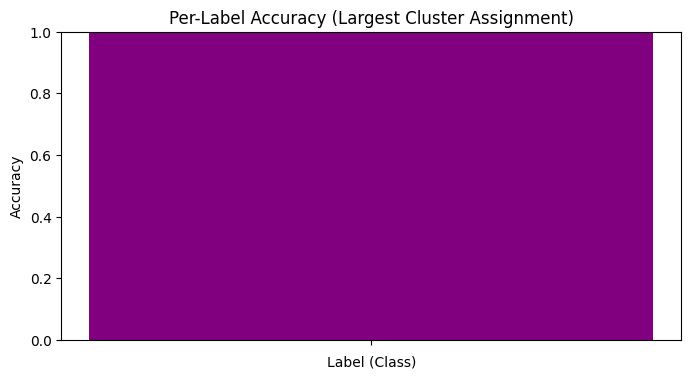

Label 0: best_cluster=1, correct=76, total=100, acc=0.7600
Label 1: best_cluster=1, correct=195, total=281, acc=0.6940
Label 2: best_cluster=0, correct=90, total=100, acc=0.9000
Label 3: best_cluster=2, correct=71, total=100, acc=0.7100
Label 4: best_cluster=2, correct=74, total=100, acc=0.7400
Label 5: best_cluster=0, correct=58, total=100, acc=0.5800
Label 6: best_cluster=0, correct=39, total=100, acc=0.3900
Label 7: best_cluster=0, correct=49, total=100, acc=0.4900
Label 8: best_cluster=0, correct=97, total=100, acc=0.9700
Label 9: best_cluster=3, correct=313, total=394, acc=0.7944
Label 10: best_cluster=0, correct=72, total=100, acc=0.7200
Label 11: best_cluster=0, correct=87, total=100, acc=0.8700
Label 12: best_cluster=0, correct=97, total=100, acc=0.9700
Label 13: best_cluster=0, correct=95, total=100, acc=0.9500
Label 14: best_cluster=0, correct=57, total=100, acc=0.5700
Label 15: best_cluster=2, correct=382, total=436, acc=0.8761
Label 16: best_cluster=0, correct=52, total=100

In [ ]:
def evaluate_class_accuracy(manager):

    #'manager.all_cluster_ids' has a cluster ID (or -1 for noise) for each image index.
    #'manager.all_labels' has the corresponding true label for each image index.
    cluster_ids = manager.all_cluster_ids
    labels = manager.all_labels

    #Filter out noise indices if you want to skip them in the analysis
    valid_indices = np.where(cluster_ids != -1)[0]
    valid_clusters = cluster_ids[valid_indices]
    valid_labels   = labels[valid_indices]

    #Build a dictionary: (cluster -> Counter of labels)
    cluster_label_counts = defaultdict(Counter)
    for i, c in zip(valid_indices, valid_clusters):
        lbl = labels[i]
        cluster_label_counts[c][lbl] += 1

    #Build a total label count
    total_label_count = Counter(valid_labels)

    #1) For each label L, find the cluster that has the maximum count of L.
    best_cluster_for_label = {}
    unique_labels = sorted(set(valid_labels))
    cluster_ids_sorted = sorted(
        c for c in set(valid_clusters) if c != -1
    )

    for L in unique_labels:
        best_cid = None
        best_count = 0
        for cid in cluster_ids_sorted:
            c_count = cluster_label_counts[cid][L]
            if c_count > best_count:
                best_count = c_count
                best_cid = cid
        best_cluster_for_label[L] = (best_cid, best_count)

    #2) Compute per-label accuracy = (# L in best cluster) / (total # L)
    print("\nPer-Label Accuracy (Using Largest-Count Cluster):")
    label_accuracies = {}
    overall_correct = 0
    overall_total   = 0
    for L in unique_labels:
        best_cid, best_count_for_L = best_cluster_for_label[L]
        total_L = total_label_count[L]
        if total_L > 0:
            acc_L = best_count_for_L / total_L
        else:
            acc_L = 0.0
        label_accuracies[L] = acc_L
        overall_correct += best_count_for_L
        overall_total   += total_L
        print(f"  Label {L}: best_cluster={best_cid}, correct={best_count_for_L}, total={total_L}, acc={acc_L:.4f}")

    overall_system_acc = overall_correct / overall_total if overall_total else 0.0
    print(f"\nOverall System Accuracy (summing per-label correct / total) = {overall_system_acc:.4f}")

    #3) Count "errors" per cluster: i.e., images in each cluster that do NOT belong
    #   to that cluster for their label's best cluster.
    print("\nPer-Cluster Error Counts:")
    cluster_error = {}
    for cid in cluster_ids_sorted:
        cluster_error[cid] = 0

    #Map label -> correct cluster
    correct_cluster_for_label = {}
    for L, (cid, _) in best_cluster_for_label.items():
        correct_cluster_for_label[L] = cid

    #Go through each valid index again, see if label's correct cluster matches
    for i in valid_indices:
        c = cluster_ids[i]
        lbl = labels[i]
        #If this cluster c is not the correct cluster for label lbl => error
        if c != correct_cluster_for_label[lbl]:
            cluster_error[c] += 1

    for cid in cluster_ids_sorted:
        size_c = len(manager.cluster_buckets[cid])
        err_c  = cluster_error[cid]
        print(f"  Cluster {cid}: size={size_c}, errors={err_c}, error_rate={err_c/size_c if size_c>0 else 0:.4f}")

    print("\nDone evaluating class accuracy.\n")

def plot_class_accuracy(manager):
    """
    Plots a bar chart of per-label accuracy using the "largest-cluster" approach.
    For each label L, we find the cluster that contains the most of L, and treat
    all L in that cluster as "correct." Then we compute accuracy = correct / total(L).

    NOTE: This function re-computes the label-cluster assignments internally, so
    you don't need to call evaluate_class_accuracy beforehand.
    """

    #Gather assigned (non-noise) indices
    cluster_ids = manager.all_cluster_ids
    labels      = manager.all_labels
    valid_indices = np.where(cluster_ids != -1)[0]
    if len(valid_indices) == 0:
        print("No non-noise assignments to evaluate.")
        return

    assigned_clusters = cluster_ids[valid_indices]
    assigned_labels   = labels[valid_indices]

    #Build cluster->(label counts)
    cluster_label_counts = defaultdict(Counter)
    for i, c in zip(valid_indices, assigned_clusters):
        lbl = labels[i]
        cluster_label_counts[c][lbl] += 1

    #Count total occurrences of each label
    total_label_count = Counter(assigned_labels)

    #For each label => best cluster
    unique_labels = sorted(set(assigned_labels))
    best_cluster_for_label = {}
    for L in unique_labels:
        best_cid = None
        best_count = 0
        for cid, lbl_counter in cluster_label_counts.items():
            c_count = lbl_counter[L]
            if c_count > best_count:
                best_count = c_count
                best_cid   = cid
        best_cluster_for_label[L] = (best_cid, best_count)

    #Compute per-label accuracy
    label_accuracies = {}
    for L in unique_labels:
        best_cid, best_count_for_L = best_cluster_for_label[L]
        total_L = total_label_count[L]
        if total_L > 0:
            label_acc = best_count_for_L / total_L
        else:
            label_acc = 0.0
        label_accuracies[L] = label_acc

    #Plot a bar chart of these per-label accuracies
    lbls_sorted = sorted(label_accuracies.keys())
    acc_values  = [label_accuracies[L] for L in lbls_sorted]

    plt.figure(figsize=(8,4))
    plt.bar([str(lbl) for lbl in lbls_sorted], acc_values, color='purple')
    plt.ylim([0, 1])
    plt.xlabel("Label (Class)")
    plt.ylabel("Accuracy")
    plt.title("Per-Label Accuracy (Largest Cluster Assignment)")
    plt.show()

    #Print numeric results & overall accuracy
    overall_correct = 0
    overall_total   = 0
    for L in lbls_sorted:
        best_cid, best_count_for_L = best_cluster_for_label[L]
        total_L = total_label_count[L]
        overall_correct += best_count_for_L
        overall_total   += total_L
        print(f"Label {L}: best_cluster={best_cid}, correct={best_count_for_L}, total={total_L}, acc={label_accuracies[L]:.4f}")

    overall_acc = overall_correct / overall_total if overall_total > 0 else 0.0
    print(f"\nOverall Accuracy (sum of per-label correct / total) = {overall_acc:.4f}")



evaluate_class_accuracy(manager)
plot_class_accuracy(manager)